In [27]:
import time

import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import pandas as pd
from rdkit import Chem
import mols.utils.chem as chem


from collections import defaultdict
import os.path
import numpy as np

from mols.utils.molMDP import BlockMoleculeData, MolMDP
import mols.utils.chem as chem
from rdkit import Chem

In [28]:
class BlockMoleculeData:

    def __init__(self):
        self.blockidxs = []       # indexes of every block
        self.blocks = []          # rdkit molecule objects for every
        self.slices = [0]         # atom index at which every block starts
        self.numblocks = 0
        self.jbonds = []          # [block1, block2, bond1, bond2]
        self.stems = []           # [block1, bond1]
        self._mol = None

    def add_block(self, block_idx, block, block_r, stem_idx, atmidx):
        """

        :param block_idx:
        :param block:
        :param block_r:
        :param stem_idx:
        :param atmidx:
        :return:
        """
        self.blockidxs.append(block_idx)
        self.blocks.append(block)
        self.slices.append(self.slices[-1] + block.GetNumAtoms())
        self.numblocks += 1
        [self.stems.append([self.numblocks-1,r]) for r in block_r[1:]]

        if len(self.blocks)==1:
            self.stems.append([self.numblocks-1, block_r[0]])
        else:
            if stem_idx is None:
                assert atmidx is not None, "need stem or atom idx"
                stem_idx = np.where(self.stem_atmidxs==atmidx)[0][0]
            else:
                assert atmidx is None, "can't use stem and atom indices at the same time"

            stem = self.stems[stem_idx]
            bond = [stem[0], self.numblocks-1, stem[1], block_r[0]]
            self.stems.pop(stem_idx)
            self.jbonds.append(bond)
            # destroy properties
            self._mol = None
        return None


    def delete_blocks(self, block_mask):
        """

        :param block_mask:
        :return:
        """

        # update number of blocks
        self.numblocks = np.sum(np.asarray(block_mask, dtype=np.int32))
        self.blocks = list(np.asarray(self.blocks)[block_mask])
        self.blockidxs = list(np.asarray(self.blockidxs)[block_mask])

        # update junction bonds
        reindex = np.cumsum(np.asarray(block_mask,np.int32)) - 1
        jbonds = []
        for bond in self.jbonds:
            if block_mask[bond[0]] and block_mask[bond[1]]:
                jbonds.append(np.array([reindex[bond[0]], reindex[bond[1]], bond[2], bond[3]]))
        self.jbonds = jbonds

        # update r-groups
        stems = []
        for stem in self.stems:
            if block_mask[stem[0]]:
                stems.append(np.array([reindex[stem[0]],stem[1]]))
        self.stems = stems

        # update slices
        natms = [block.GetNumAtoms() for block in self.blocks]
        self.slices = [0] + list(np.cumsum(natms))

        # destroy properties
        self._mol = None
        return reindex

    def remove_jbond(self, jbond_idx=None, atmidx=None):

        if jbond_idx is None:
            assert atmidx is not None, "need jbond or atom idx"
            jbond_idx = np.where(self.jbond_atmidxs == atmidx)[0][0]
        else:
            assert atmidx is None, "can't use stem and atom indices at the same time"

        # find index of the junction bond to remove
        jbond = self.jbonds.pop(jbond_idx)

        # find the largest connected component; delete rest
        jbonds = np.asarray(self.jbonds, dtype=np.int32)
        jbonds = jbonds.reshape([len(self.jbonds),4]) # handle the case when single last jbond was deleted
        graph = csr_matrix((np.ones(self.numblocks-2),
                            (jbonds[:,0], jbonds[:,1])),
                           shape=(self.numblocks, self.numblocks))
        _, components = connected_components(csgraph=graph, directed=False, return_labels=True)
        block_mask = components==np.argmax(np.bincount(components))
        reindex = self.delete_blocks(block_mask)

        if block_mask[jbond[0]]:
            stem = np.asarray([reindex[jbond[0]], jbond[2]])
        else:
            stem = np.asarray([reindex[jbond[1]], jbond[3]])
        self.stems.append(stem)
        atmidx = self.slices[stem[0]] + stem[1]
        return atmidx

    @property
    def stem_atmidxs(self):
        stems = np.asarray(self.stems)
        if stems.shape[0]==0:
            stem_atmidxs = np.array([])
        else:
            stem_atmidxs = np.asarray(self.slices)[stems[:,0]] + stems[:,1]
        return stem_atmidxs

    @property
    def jbond_atmidxs(self):
        jbonds = np.asarray(self.jbonds)
        if jbonds.shape[0]==0:
            jbond_atmidxs = np.array([])
        else:
            jbond_atmidxs = np.stack([np.concatenate([np.asarray(self.slices)[jbonds[:,0]] + jbonds[:,2]]),
                                      np.concatenate([np.asarray(self.slices)[jbonds[:,1]] + jbonds[:,3]])],1)
        return jbond_atmidxs

    @property
    def mol(self):
        if self._mol == None:
            self._mol, _ = chem.mol_from_frag(jun_bonds=self.jbonds, frags=self.blocks)
        return self._mol

    @property
    def smiles(self):
        return Chem.MolToSmiles(self.mol)

In [29]:
class BlockMoleculeDataExtended(BlockMoleculeData):

    @property
    def mol(self):
        return chem.mol_from_frag(jun_bonds=self.jbonds, frags=self.blocks)[0]

    @property
    def smiles(self):
        return Chem.MolToSmiles(self.mol)

    def copy(self): # shallow copy
        o = BlockMoleculeDataExtended()
        o.blockidxs = list(self.blockidxs)
        o.blocks = list(self.blocks)
        o.slices = list(self.slices)
        o.numblocks = self.numblocks
        o.jbonds = list(self.jbonds)
        o.stems = list(self.stems)
        return o

    def as_dict(self):
        return {'blockidxs': self.blockidxs,
                'slices': self.slices,
                'numblocks': self.numblocks,
                'jbonds': self.jbonds,
                'stems': self.stems}

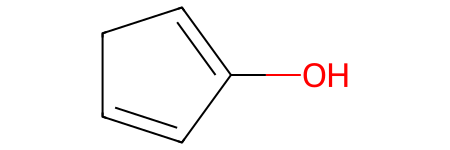

In [30]:
from rdkit.Chem import Draw

smile1 = 'CC(O)=C(Cl)C'
block1 = Chem.MolFromSmiles(smile1)

smiles = 'C1CC=C(C(CCl)CO)CC1'
mol = Chem.MolFromSmiles(smiles)


smile3 = 'OC1=CCC=C1'
mol = Chem.MolFromSmiles(smile3)
mol

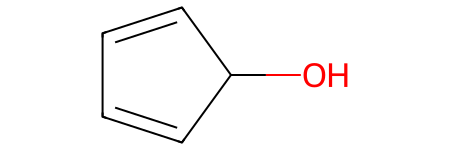

In [31]:
graph_1 = BlockMoleculeData()
ring = Chem.MolFromSmiles('C1C=CC=C1')   # <-- note the initial **C**, not C=
graph_1.add_block(
    block_idx = 0,
    block     = ring,
    block_r   = [0],     # leave atom-0 with one open valence
    stem_idx  = None,
    atmidx    = None
)

# 2) OH fragment attaches to the open stem
oh = Chem.MolFromSmiles('O')
graph_1.add_block(
    block_idx = 1,
    block     = oh,
    block_r   = [0],     # connect via the oxygen
    stem_idx  = 0,       # use the only open stem created above
    atmidx    = None
)

# graph_1.add_block(
#     block_idx = 2,
#     block = Chem.MolFromSmiles('C'),
#     block_r = [0],
#     stem_idx = 1,
#     atmidx=None
# )


mol = Chem.MolFromSmiles(graph_1.smiles)
mol

### For debugging, use:-

In [32]:
ring = Chem.MolFromSmiles('C1C=CC=C1')
for i, atom in enumerate(ring.GetAtoms()):
    print(f"Atom {i}: {atom.GetSymbol()}, Degree: {atom.GetDegree()}, Valence: {atom.GetExplicitValence()}")

for bond in ring.GetBonds():
    print(f"Bond: {bond.GetBeginAtomIdx()} - {bond.GetEndAtomIdx()} : {bond.GetBondType()}")


Atom 0: C, Degree: 2, Valence: 2
Atom 1: C, Degree: 2, Valence: 3
Atom 2: C, Degree: 2, Valence: 3
Atom 3: C, Degree: 2, Valence: 3
Atom 4: C, Degree: 2, Valence: 3
Bond: 0 - 1 : SINGLE
Bond: 1 - 2 : DOUBLE
Bond: 2 - 3 : SINGLE
Bond: 3 - 4 : DOUBLE
Bond: 4 - 0 : SINGLE


[16:52:35] DEPRECATION WARNING: please use GetValence(which=)
[16:52:35] DEPRECATION WARNING: please use GetValence(which=)
[16:52:35] DEPRECATION WARNING: please use GetValence(which=)
[16:52:35] DEPRECATION WARNING: please use GetValence(which=)
[16:52:35] DEPRECATION WARNING: please use GetValence(which=)


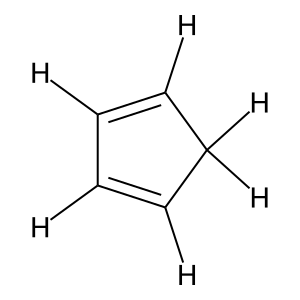

In [33]:
mol = Chem.MolFromSmiles('C1C=CC=C1')
Draw.MolToImage(mol, legend="Cyclopentadiene")
Draw.MolToImage(Chem.rdmolops.AddHs(mol), size=(300,300), kekulize=True, wedgeBonds=True)

## An important note for Block Building

You saw that [0,0] (the smallest atom index) ended up last, not first. That’s intentional:

We put all the “future” stems first (block_r[1:]), so you can consume them in the order you listed them.

We leave the “primary” stem (block_r[0]) at the end, because that’s the one you’d normally hook up immediately to a downstream block—so it’s easiest to grab as the last element (index = len(stems)-1) when you do stem_idx=None on the next add_block.

So, the workflow is:-

`block_r => block_r[1:] => stems => stem_idx`

[1 2 4 0]


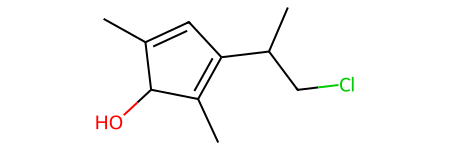

In [34]:
from rdkit import Chem
from rdkit.Chem import Draw
from mols.utils.molMDP import BlockMoleculeData

# 1. Initialize the graph
graph = BlockMoleculeData()

# 2. Add the cyclopentadiene ring with three R-group stems:
#    - block_r[0] = 0 → for the OH
#    - block_r[1] = 1 → for the first Me
#    - block_r[2] = 4 → for the second Me
ring = Chem.MolFromSmiles('C1C=CC=C1')
graph.add_block(
    block_idx = 0,
    block     = ring,
    block_r   = [0, 1, 2, 4],
    stem_idx  = None,
    atmidx    = None
)
# Internally, graph.stems is now [[0,1], [0,4], [0,0]]
# print(graph.stems)


print(graph.stem_atmidxs)

# 3. Attach the OH to C0 → that was the *third* stem in the list (index 2)
oh = Chem.MolFromSmiles('O')
graph.add_block(
    block_idx = 1,
    block     = oh,
    block_r   = [0],
    stem_idx  = 3,
    atmidx    = None
)
# Consumes stem [0,0], leaving stems = [[0,1], [0,4]]

# print(graph.stems)

# 4. Attach the first Me to C1 → now at stems[0]
me1 = Chem.MolFromSmiles('C')
graph.add_block(
    block_idx = 2,
    block     = me1,
    block_r   = [0],
    stem_idx  = 0,
    atmidx    = None
)
# Consumes stem [0,1], leaving stems = [[0,4]]

# print(graph.stems)

# 5. Attach the second Me to C4 → now at stems[0] again
me2 = Chem.MolFromSmiles('C')
graph.add_block(
    block_idx = 3,
    block     = me2,
    block_r   = [0],
    stem_idx  = 1,
    atmidx    = None
)

# print(graph.stems)

prp = Chem.MolFromSmiles('C(CCl)C')
graph.add_block(
    block_idx = 4,
    block = prp,
    block_r = [0],
    stem_idx = 0,
    atmidx=None
)


# All stems consumed

# 6. Inspect the result
graph.mol


In [35]:
# No stems remaining now; as all were consumed by the blocks!!
graph.stems

[]

In [36]:
# A junction bond connects two blocks by bonding specific atoms in each (Note that we added individual blocks using the add_block() method)
# Format: [block1_idx, block2_idx, bond1_idx, bond2_idx]

# In our example:-
# block1 => different branches
# block2 => cyclopentadiene
graph.jbonds

[[0, 1, 0, 0], [0, 2, 1, 0], [0, 3, 4, 0], [0, 4, 2, 0]]

In [37]:
graph.jbond_atmidxs

array([[0, 5],
       [1, 6],
       [4, 7],
       [2, 8]])

In [54]:
from copy import deepcopy
graph_cpy = deepcopy(graph)

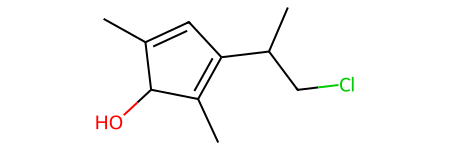

In [53]:
graph_cpy.mol

No of blocks: 5


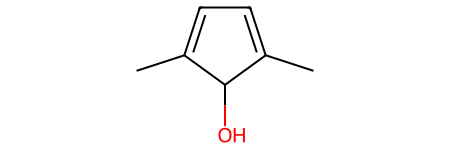

In [56]:
print(f"No of blocks: {len(graph_cpy.blocks)}")


graph_cpy.delete_blocks([True, True, True, True, False])
graph_cpy.mol

### Use of atmidx:-

Available stem atom indices: [1 2 3 4 0]
Final SMILES: CC1=CCC=C1


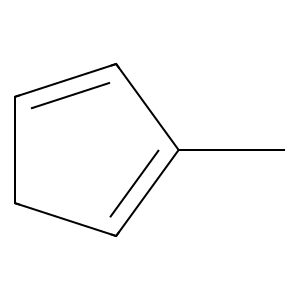

In [39]:
g = BlockMoleculeData()


ring = Chem.MolFromSmiles('C1C=CC=C1')
g.add_block(
    block_idx=0, 
    block=ring, 
    block_r=[0,1, 2, 3, 4], 
    stem_idx=None, 
    atmidx=None
)
# Internally: stems == [[0,1], [0,0]]


# 3. Now we want to attach CH3 to ring atom-1, but we only know it's atom index = 1:
print("Available stem atom indices:", g.stem_atmidxs)  # e.g. [1]

# Use atmidx=1 to pick that stem:
g.add_block(
    block_idx = 2,
    block     = Chem.MolFromSmiles('C'),
    block_r   = [0],
    stem_idx  = None,     # we’re not using stem_idx now
    atmidx    = 2
)


print("Final SMILES:", g.smiles)
Draw.MolToImage(g.mol)